In [ ]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.combine import SMOTETomek

# Load the data
train_df = pd.read_parquet("../preprocessed_train_data.parquet")
test_df = pd.read_parquet("../preprocessed_test_data.parquet")


In [ ]:
import os
os.environ['OMP_NUM_THREADS'] = '4' 
os.environ['OPENBLAS_NUM_THREADS'] = '4'
os.environ['MKL_NUM_THREADS'] = '4'
os.environ['VECLIB_MAXIMUM_THREADS'] = '4'
os.environ['NUMEXPR_NUM_THREADS'] = '4'

In [57]:
# Check dataset sizes
print(f"Train set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Train set shape: (3888468, 11)
Test set shape: (747411, 22)


In [58]:
train_df["FlagImpaye"] = train_df["FlagImpaye"].astype(int)
test_df["FlagImpaye"] = test_df["FlagImpaye"].astype(int)

In [59]:
remaining_columns = train_df.columns
test_df = test_df[remaining_columns]

In [60]:
test_df.columns

Index(['FlagImpaye', 'Montant', 'VerifianceCPT2', 'D2CB', 'ScoringFP1',
       'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM',
       'CA3TRetMtt', 'Heure'],
      dtype='object')

In [61]:
train_df.columns

Index(['FlagImpaye', 'Montant', 'VerifianceCPT2', 'D2CB', 'ScoringFP1',
       'ScoringFP2', 'ScoringFP3', 'TauxImpNb_RB', 'TauxImpNB_CPM',
       'CA3TRetMtt', 'Heure'],
      dtype='object')

C:\Users\MSI\AppData\Local\Temp\ipykernel_16668\2393893868.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")


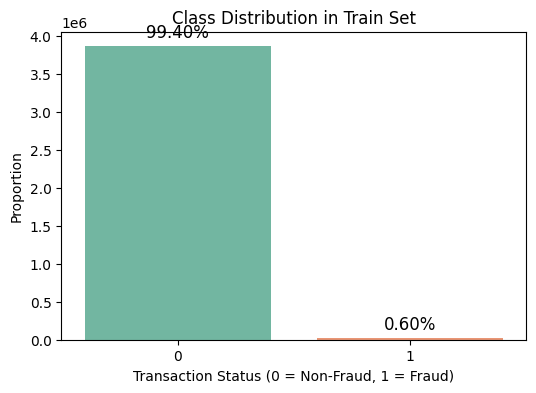

In [62]:
# Visualizing class distribution in Train Set
plt.figure(figsize=(6, 4))
sns.countplot(x="FlagImpaye", data=train_df, palette="Set2")
plt.title("Class Distribution in Train Set")
plt.xlabel("Transaction Status (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Proportion")

# Adding percentage labels
total_train = len(train_df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total_train:.2f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                       textcoords='offset points')
plt.show()

C:\Users\MSI\AppData\Local\Temp\ipykernel_16668\1591727164.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="FlagImpaye", data=test_df, palette="Set3")


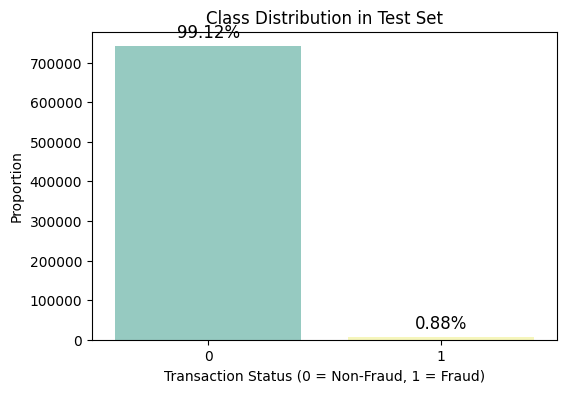

In [63]:
# Visualizing class distribution in Test Set
plt.figure(figsize=(6, 4))
sns.countplot(x="FlagImpaye", data=test_df, palette="Set3")
plt.title("Class Distribution in Test Set")
plt.xlabel("Transaction Status (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Proportion")

# Adding percentage labels
total_test = len(test_df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total_test:.2f}%'
    plt.gca().annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 10),
                       textcoords='offset points')
plt.show()


In [64]:
X_train = train_df.drop(columns=["FlagImpaye"])
y_train = train_df["FlagImpaye"]

In [65]:
X_test = test_df.drop(columns=["FlagImpaye"])
y_test = test_df["FlagImpaye"]

In [66]:
# Définir la pipeline avec SMOTETomek + RandomForest
pipeline = Pipeline([
    ('under', SMOTETomek(sampling_strategy=0.2,random_state=42)),
    ('clf', RandomForestClassifier(
        n_estimators=200, 
        min_samples_split=2, 
        max_depth=None, 
        random_state=42, 
        n_jobs=8
    ))
])

In [67]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [68]:
# Évaluation avec la cross-validation
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='f1')

print(f"F1 Score moyen en cross-validation : {np.mean(f1_scores):.4f}")

F1 Score moyen en cross-validation : 0.5850


In [69]:
pipeline.fit(X_train, y_train)


Pipeline(steps=[('under', SMOTETomek(random_state=42, sampling_strategy=0.2)),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=8,
                                        random_state=42))])

In [70]:
y_pred = pipeline.predict(X_test)


In [71]:
# Rapport de classification
print("\n=== Rapport de classification sur le jeu de test ===")
print(classification_report(y_test, y_pred))


=== Rapport de classification sur le jeu de test ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    740838
           1       0.06      0.12      0.08      6573

    accuracy                           0.97    747411
   macro avg       0.52      0.55      0.53    747411
weighted avg       0.98      0.97      0.98    747411



In [73]:
import joblib
# Sauvegarder le modèle entraîné

joblib.dump(pipeline, "smotetomek_rf.pkl")
print("Pipeline sauvegardée dans smotetomek_rf.pkl")

Pipeline sauvegardée dans smotetomek_rf.pkl
